# QuIC Seminar: Variational Quantum Eigensolver

This notebook implements the VQE algorithm for H2, as described in the paper [1].

<img src="http://www.theplanteater.com/wp-content/uploads/2018/02/HydrogenMolecule.png" alt="H2" style="width:300px;height:300px;">

In [1]:
"""Install pyQuil, if necessary."""
#!pip install pyquil

'Install pyQuil, if necessary.'

In [2]:
"""Imports for the notebook."""
from numpy import array, pi
from numpy.random import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from pyquil import Program, get_qc
from pyquil.gates import RX, RZ, RY, CNOT, I, MEASURE

In [3]:
"""Suppress all warnings (not recommended!) for not declaring classical registers."""
import warnings
warnings.filterwarnings("ignore")

# The Hamiltonian for $H_2$

The Hamiltonian for $H_2$ can be written [1]

\begin{equation}
    H = g_0 I + g_1 Z_0 + g_2 Z_1 + g_3 Z_0 Z_1 + g_4 X_0 X_1 + g_5 Y_0 Y_1
\end{equation}

where $g_i$ are numerical values that depend on the bond length $R$ between Hydrogren molecules. This writing of the Hamiltonian:

1. Uses the minimal [STO-6G basis](https://en.wikipedia.org/wiki/STO-nG_basis_sets),
1. Uses the Bravyi-Kitaev transform, and
1. Reduces resources (qubit number) by symmetry considerations (see paper).

Each coefficient $g_i$ is specified below, where the first column is the bond length $R$.

In [4]:
"""The organization of the numeric values in the table below is

RADIUS  | g0    | g1    | g2    | g3    | g4    | g5

where it is understood each g is a function of the RADIUS R.

Source: Table 1 of Appendix C of [1].
"""

table = array([
        [0.2000, 2.8489, 0.5678, -1.4508, 0.6799, 0.07910, 0.07910],
        [0.2500, 2.1868, 0.5449, -1.2870, 0.6719, 0.07980, 0.07980],
        [0.3000, 1.7252, 0.5215, -1.1458, 0.6631, 0.08060, 0.08060],
        [0.3500, 1.3827, 0.4982, -1.0226, 0.6537, 0.08150, 0.08150],
        [0.4000, 1.1182, 0.4754, -0.9145, 0.6438, 0.08250, 0.08250],
        [0.4500, 0.9083, 0.4534, -0.8194, 0.6336, 0.08350, 0.08350],
        [0.5000, 0.7381, 0.4325, -0.7355, 0.6233, 0.08460, 0.08460],
        [0.5500, 0.5979, 0.4125, -0.6612, 0.6129, 0.08580, 0.08580],
        [0.6000, 0.4808, 0.3937, -0.5950, 0.6025, 0.08700, 0.08700],
        [0.6500, 0.3819, 0.3760, -0.5358, 0.5921, 0.08830, 0.08830],
        [0.7000, 0.2976, 0.3593, -0.4826, 0.5818, 0.08960, 0.08960],
        [0.7500, 0.2252, 0.3435, -0.4347, 0.5716, 0.09100, 0.09100],
        [0.8000, 0.1626, 0.3288, -0.3915, 0.5616, 0.09250, 0.09250],
        [0.8500, 0.1083, 0.3149, -0.3523, 0.5518, 0.09390, 0.09390],
        [0.9000, 0.06090, 0.3018, -0.3168, 0.5421, 0.09540, 0.09540],
        [0.9500, 0.01930, 0.2895, -0.2845, 0.5327, 0.09700, 0.09700],
        [1.000, -0.01720, 0.2779, -0.2550, 0.5235, 0.09860, 0.09860],
        [1.050, -0.04930, 0.2669, -0.2282, 0.5146, 0.1002, 0.1002],
        [1.100, -0.07780, 0.2565, -0.2036, 0.5059, 0.1018, 0.1018],
        [1.150, -0.1029, 0.2467, -0.1810, 0.4974, 0.1034, 0.1034],
        [1.200, -0.1253, 0.2374, -0.1603, 0.4892, 0.1050, 0.1050],
        [1.250, -0.1452, 0.2286, -0.1413, 0.4812, 0.1067, 0.1067],
        [1.300, -0.1629, 0.2203, -0.1238, 0.4735, 0.1083, 0.1083],
        [1.350, -0.1786, 0.2123, -0.1077, 0.4660, 0.1100, 0.1100],
        [1.400, -0.1927, 0.2048, -0.09290, 0.4588, 0.1116, 0.1116],
        [1.450, -0.2053, 0.1976, -0.07920, 0.4518, 0.1133, 0.1133],
        [1.500, -0.2165, 0.1908, -0.06660, 0.4451, 0.1149, 0.1149],
        [1.550, -0.2265, 0.1843, -0.05490, 0.4386, 0.1165, 0.1165],
        [1.600, -0.2355, 0.1782, -0.04420, 0.4323, 0.1181, 0.1181],
        [1.650, -0.2436, 0.1723, -0.03420, 0.4262, 0.1196, 0.1196],
        [1.700, -0.2508, 0.1667, -0.02510, 0.4204, 0.1211, 0.1211],
        [1.750, -0.2573, 0.1615, -0.01660, 0.4148, 0.1226, 0.1226],
        [1.800, -0.2632, 0.1565, -0.00880, 0.4094, 0.1241, 0.1241],
        [1.850, -0.2684, 0.1517, -0.00150, 0.4042, 0.1256, 0.1256],
        [1.900, -0.2731, 0.1472, 0.005200, 0.3992, 0.1270, 0.1270],
        [1.950, -0.2774, 0.1430, 0.01140, 0.3944, 0.1284, 0.1284],
        [2.000, -0.2812, 0.1390, 0.01710, 0.3898, 0.1297, 0.1297],
        [2.050, -0.2847, 0.1352, 0.02230, 0.3853, 0.1310, 0.1310],
        [2.100, -0.2879, 0.1316, 0.02720, 0.3811, 0.1323, 0.1323],
        [2.150, -0.2908, 0.1282, 0.03170, 0.3769, 0.1335, 0.1335],
        [2.200, -0.2934, 0.1251, 0.03590, 0.3730, 0.1347, 0.1347],
        [2.250, -0.2958, 0.1221, 0.03970, 0.3692, 0.1359, 0.1359],
        [2.300, -0.2980, 0.1193, 0.04320, 0.3655, 0.1370, 0.1370],
        [2.350, -0.3000, 0.1167, 0.04650, 0.3620, 0.1381, 0.1381],
        [2.400, -0.3018, 0.1142, 0.04950, 0.3586, 0.1392, 0.1392],
        [2.450, -0.3035, 0.1119, 0.05230, 0.3553, 0.1402, 0.1402],
        [2.500, -0.3051, 0.1098, 0.05490, 0.3521, 0.1412, 0.1412],
        [2.550, -0.3066, 0.1078, 0.05720, 0.3491, 0.1422, 0.1422],
        [2.600, -0.3079, 0.1059, 0.05940, 0.3461, 0.1432, 0.1432],
        [2.650, -0.3092, 0.1042, 0.06140, 0.3433, 0.1441, 0.1441],
        [2.700, -0.3104, 0.1026, 0.06320, 0.3406, 0.1450, 0.1450],
        [2.750, -0.3115, 0.1011, 0.06490, 0.3379, 0.1458, 0.1458],
        [2.800, -0.3125, 0.09970, 0.06650, 0.3354, 0.1467, 0.1467],
        [2.850, -0.3135, 0.09840, 0.06790, 0.3329, 0.1475, 0.1475]
])

To speed up the process, we'll reduce the number of bond lengths we consider.

In [5]:
"""Reduce the number of bond lengths considered."""
# only consider the first N bond lengths, and increase the spacing
N = 50
step = 2

# grab the reduced coeffs and bond lengths
table = table[0:N:step]
radii = table[:, 0]
coeffs = table[:, 1:]

# show the reduced set of coefficients at each bond length
print("Bond lengths (Angstroms):")
print(*radii, sep="\n")

print("Coefficients (Hartree):")
print(*coeffs, sep="\n")

Bond lengths (Angstroms):
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
Coefficients (Hartree):
[ 2.8489  0.5678 -1.4508  0.6799  0.0791  0.0791]
[ 1.7252  0.5215 -1.1458  0.6631  0.0806  0.0806]
[ 1.1182  0.4754 -0.9145  0.6438  0.0825  0.0825]
[ 0.7381  0.4325 -0.7355  0.6233  0.0846  0.0846]
[ 0.4808  0.3937 -0.595   0.6025  0.087   0.087 ]
[ 0.2976  0.3593 -0.4826  0.5818  0.0896  0.0896]
[ 0.1626  0.3288 -0.3915  0.5616  0.0925  0.0925]
[ 0.0609  0.3018 -0.3168  0.5421  0.0954  0.0954]
[-0.0172  0.2779 -0.255   0.5235  0.0986  0.0986]
[-0.0778  0.2565 -0.2036  0.5059  0.1018  0.1018]
[-0.1253  0.2374 -0.1603  0.4892  0.105   0.105 ]
[-0.1629  0.2203 -0.1238  0.4735  0.1083  0.1083]
[-0.1927  0.2048 -0.0929  0.4588  0.1116  0.1116]
[-0.2165  0.1908 -0.0666  0.4451  0.1149  0.1149]
[-0.2355  0.1782 -0.0442  0.4323  0.1181  0.1181]
[-0.2508  0.1667 -0.0251  0.4204  0.1211  0.1211]
[-0.2632  0.1565 -0.0088  0.4094  0.1241  0.1241]


# Constructing the Circuit

The circuit implemented is shown in Figure 1 of [1]. 

Depending on which term of the Hamiltonian we're computing the expectation value of, we need to implement an appropriate set of gates to rotate to the eigenbasis. The appropriate set of gates, keeping the ordering of terms in the Hamiltonian above, is defined below.

In [6]:
"""Defining rotation operators in a dictionary. 

key = which term of Hamiltonian, value = which rotation to implement.
"""

rotations = {1: Program(I(0), MEASURE(0, 0)),
             2: Program(I(1), MEASURE(1, 0)),
             3: Program(I(0), I(1), MEASURE(0, 0), MEASURE(1, 1)),
             4: Program(RY(-pi / 2, 0), RY(-pi / 2, 1), MEASURE(0, 0), MEASURE(1, 1)),
             5: Program(RX(pi / 2, 0), RX(pi / 2, 1), MEASURE(0, 0), MEASURE(1, 1))}

In [7]:
def circuit(k, theta):
    """Returns the program for computing the expectation value
    
    <H_k> = <\psi(\theta)| H_k |\psi(theta)>
    
    where H_k is the k'th term in the Hamiltonian H
    and theta is the variational parameter.
    """
    # ansatz
    prog = Program(
        RX(pi, 0),
        RY(pi / 2, 1),
        RX(-pi / 2, 0),
        CNOT(1, 0),
        RZ(theta[0], 0),
        CNOT(1, 0),
        RY(-pi / 2, 1),
        RX(pi / 2, 0)
    )
    
    # rotations to measure in the eigenbasis
    prog += rotations[k]
    
    return prog

In [8]:
"""Display an example circuit."""
# term in the Hamiltonian
k = 1

# circuit for this term (set the variational parameter to be zero)
print(circuit(1, [0]))

DECLARE ro BIT[1]
RX(pi) 0
RY(pi/2) 1
RX(-pi/2) 0
CNOT 1 0
RZ(0) 0
CNOT 1 0
RY(-pi/2) 1
RX(pi/2) 0
I 0
MEASURE 0 ro[0]



# Computing the Expectation

We now write a function to compute the expectation of the $k$th term in our Hamiltonian. Since we have a function for constructing the circuit, we just need to run it and process the output.

In [9]:
def expectation(k, theta, computer, shots=10000):
    # get the circuit to run
    circ = circuit(k, theta)
    
    # set the number of shots
    circ.wrap_in_numshots_loop(shots)
    
    # execute the circuit
    res = computer.run(circ)
    
    # do the postprocessing
    tot = 0.0
    for vals in res:
        tot += (-1)**sum(vals)
    return tot / shots

In [10]:
"""Compute an example expectation."""
computer = get_qc("2q-qvm")
expectation(1, [0], computer)

-1.0

# Weighting the Expectation

Now that we can compute expectations, we just need to weight them with the appropriate coefficient, which is done classically.

In [11]:
def term(r, k, theta, shots=1000):
    """Computes one term of <H>.
    
    Args:
        r : int
            Index of the radii (bond length).
        
        k : int
            Index of the term in the coefficient.
            
        theta : list<float>
            Parameter in RZ gate in circuit.
            
        shots : int
            Number of times to simulate the circuit.
    """
    coeff = coeffs[r][k]
    computer = get_qc("2q-qvm")
    return coeff * expectation(k, theta, computer, shots)

In [12]:
"""Compute an example term."""
term(r=0, k=1, theta=[0])

-0.5678

# Computing the Total Energy

Now we can define a function that computes the expectation for all terms at a particular bond length (radii).

In [13]:
def energy(r, theta):
    """Computes the energy at a given bond length radii[r]."""
    # initialize the energy
    tot = 0.0
    
    # add all terms (weighted expectations)
    for k in range(1, 5 + 1):
        tot += term(r, k, theta)
        
    # add the constant shift
    tot += coeffs[r][0]

    # return the value
    return tot

In [14]:
"""Compute the energy for an example radii and example variational parameter."""
energy(0, [0])

0.15593699999999977

# Minimizing the Total Energy

Here we define our objective function for a given radii index `r`. The objective function is just a function of our parameter $\theta$ that we are trying to minimize.

In [15]:
def obj(theta):
    en = energy(0, theta)
    print(en, end="\r")
    return en

Now we can use a (classical) optimization algorithm to minimize the objective.

In [16]:
opt = minimize(obj, x0=[0], method="Powell")

In [17]:
opt.fun

0.13806040000000008

# Computing the Potential Energy Surface

Now we loop through all bond lengths and minimize the total energy at each one. Since we haven't seen our bond lengths or coefficients in a while, we'll print them out here.

In [18]:
"""Don't forget the bond lengths and coefficients!"""
print("Bond lengths (Angstroms):")
print(*radii, sep="\n")

print("Coefficients (Hartree):")
print(*coeffs, sep="\n")

Bond lengths (Angstroms):
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
Coefficients (Hartree):
[ 2.8489  0.5678 -1.4508  0.6799  0.0791  0.0791]
[ 1.7252  0.5215 -1.1458  0.6631  0.0806  0.0806]
[ 1.1182  0.4754 -0.9145  0.6438  0.0825  0.0825]
[ 0.7381  0.4325 -0.7355  0.6233  0.0846  0.0846]
[ 0.4808  0.3937 -0.595   0.6025  0.087   0.087 ]
[ 0.2976  0.3593 -0.4826  0.5818  0.0896  0.0896]
[ 0.1626  0.3288 -0.3915  0.5616  0.0925  0.0925]
[ 0.0609  0.3018 -0.3168  0.5421  0.0954  0.0954]
[-0.0172  0.2779 -0.255   0.5235  0.0986  0.0986]
[-0.0778  0.2565 -0.2036  0.5059  0.1018  0.1018]
[-0.1253  0.2374 -0.1603  0.4892  0.105   0.105 ]
[-0.1629  0.2203 -0.1238  0.4735  0.1083  0.1083]
[-0.1927  0.2048 -0.0929  0.4588  0.1116  0.1116]
[-0.2165  0.1908 -0.0666  0.4451  0.1149  0.1149]
[-0.2355  0.1782 -0.0442  0.4323  0.1181  0.1181]
[-0.2508  0.1667 -0.0251  0.4204  0.1211  0.1211]
[-0.2632  0.1565 -0.0088  0.4094  0.1241  0.1241]


In [19]:
"""Compute the minimum energy at each bond length."""
energies = []
for r in range(len(radii)):
    # status update
    print("Current bond length:", radii[r], "Angstroms.")
    
    # define the objective function for this radius
    obj = lambda theta: energy(r, theta)
    
    # compute the minimum energy
    opt = minimize(obj, x0=[0], method="Powell")
    
    # append the minimum energy to the list
    energies.append(opt.fun)

Current bond length: 0.2
Current bond length: 0.3
Current bond length: 0.4
Current bond length: 0.5
Current bond length: 0.6
Current bond length: 0.7
Current bond length: 0.8
Current bond length: 0.9
Current bond length: 1.0
Current bond length: 1.1
Current bond length: 1.2
Current bond length: 1.3
Current bond length: 1.4
Current bond length: 1.5
Current bond length: 1.6
Current bond length: 1.7
Current bond length: 1.8
Current bond length: 1.9
Current bond length: 2.0
Current bond length: 2.1
Current bond length: 2.2
Current bond length: 2.3
Current bond length: 2.4
Current bond length: 2.5
Current bond length: 2.6


# Plotting the Potential Energy Surface

We can now visualize the potential energy surface by plotting energies (in Hartree) at each bond length (in Angstroms).

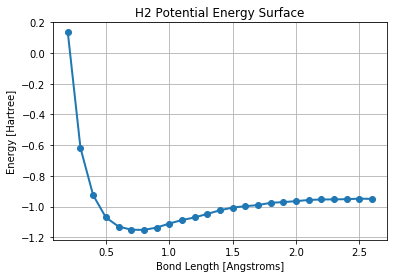

In [25]:
"""Plot the potential energy surface."""
plt.plot(radii, energies, "-o", linewidth=2)
plt.grid()
plt.title("H2 Potential Energy Surface")
plt.xlabel("Bond Length [Angstroms]")
plt.ylabel("Energy [Hartree]")

plt.show()

## References

Many thanks to Yousif Almulla for translating the coefficients into code and providing an initial program.

[1] P. J. J. O’Malley et al., “Scalable Quantum Simulation of Molecular Energies,” 
Physical Review X, vol. 6, no. 3, Jul. 2016.